# Near-Earth Objects: Predicting Hazardous Potential

This notebook aims to predict whether a near-earth object (NEO) is hazardous based on its characteristics. The data is from a dataset by NASA in which they have a column called 'is_hazardous'. This column is the target variable that will be predicted by the model using the data given.

We will build and evaluate two different machine learning models: Logistic Regression and Random Forest. The best-performing model will be chosen based on its accuracy and other performance metrics.


### Import libraries

In [103]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

### Load Dataset

In [9]:
df = pd.read_csv('nearest-earth-objects(1910-2024).csv')

In [11]:
df.head()


,neo_id,name,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,orbiting_body,relative_velocity,miss_distance,is_hazardous
0,2162117,162117 (1998 SD15),19.14,0.394962,0.883161,Earth,71745.401048,5.814362e+07,False
1,2349507,349507 (2008 QY),18.50,0.530341,1.185878,Earth,109949.757148,5.580105e+07,True
2,2455415,455415 (2003 GA),21.45,0.136319,0.304818,Earth,24865.506798,6.720689e+07,False
3,3132126,(2002 PB),20.63,0.198863,0.444672,Earth,78890.076805,3.039644e+07,False
4,3557844,(2011 DW),22.70,0.076658,0.171412,Earth,56036.519484,6.311863e+07,False


## Data Cleaning

In [13]:
df_clean = df.dropna()
df_clean.shape

(338171, 9)

In [15]:
null_counts = df_clean.isnull().sum()
null_counts

neo_id                    0
name                      0
absolute_magnitude        0
estimated_diameter_min    0
estimated_diameter_max    0
orbiting_body             0
relative_velocity         0
miss_distance             0
is_hazardous              0
dtype: int64

In [17]:
df_clean.dtypes

neo_id                      int64
name                       object
absolute_magnitude        float64
estimated_diameter_min    float64
estimated_diameter_max    float64
orbiting_body              object
relative_velocity         float64
miss_distance             float64
is_hazardous                 bool
dtype: object

In [19]:
df_c = df_clean.copy()

In [21]:
df_c

,neo_id,name,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,orbiting_body,relative_velocity,miss_distance,is_hazardous
0,2162117,162117 (1998 SD15),19.140,0.394962,0.883161,Earth,71745.401048,5.814362e+07,False
1,2349507,349507 (2008 QY),18.500,0.530341,1.185878,Earth,109949.757148,5.580105e+07,True
2,2455415,455415 (2003 GA),21.450,0.136319,0.304818,Earth,24865.506798,6.720689e+07,False
3,3132126,(2002 PB),20.630,0.198863,0.444672,Earth,78890.076805,3.039644e+07,False
4,3557844,(2011 DW),22.700,0.076658,0.171412,Earth,56036.519484,6.311863e+07,False
...,...,...,...,...,...,...,...,...,...
338194,54403809,(2023 VS4),28.580,0.005112,0.011430,Earth,56646.985988,6.406548e+07,False
338195,54415298,(2023 XW5),28.690,0.004859,0.010865,Earth,21130.768947,2.948883e+07,False
338196,54454871,(2024 KJ7),21.919,0.109839,0.245607,Earth,11832.041031,5.346078e+07,False
338197,54456245,(2024 NE),23.887,0.044377,0.099229,Earth,56198.382733,5.184742e+06,False


#### Dropping unecessary columns 

In [23]:
df_c = df_c.drop(['neo_id','estimated_diameter_max','estimated_diameter_min','orbiting_body' ], axis = 1)

In [25]:
df_c

,name,absolute_magnitude,relative_velocity,miss_distance,is_hazardous
0,162117 (1998 SD15),19.140,71745.401048,5.814362e+07,False
1,349507 (2008 QY),18.500,109949.757148,5.580105e+07,True
2,455415 (2003 GA),21.450,24865.506798,6.720689e+07,False
3,(2002 PB),20.630,78890.076805,3.039644e+07,False
4,(2011 DW),22.700,56036.519484,6.311863e+07,False
...,...,...,...,...,...
338194,(2023 VS4),28.580,56646.985988,6.406548e+07,False
338195,(2023 XW5),28.690,21130.768947,2.948883e+07,False
338196,(2024 KJ7),21.919,11832.041031,5.346078e+07,False
338197,(2024 NE),23.887,56198.382733,5.184742e+06,False


#### Encoding the categorical variables

In [27]:
label_encoder = LabelEncoder()
df_c['name'] = label_encoder.fit_transform(df_c['name'])
df_c['is_hazardous'] = label_encoder.fit_transform(df_c['is_hazardous'])
df_c

,name,absolute_magnitude,relative_velocity,miss_distance,is_hazardous
0,30600,19.140,71745.401048,5.814362e+07,0
1,31392,18.500,109949.757148,5.580105e+07,1
2,32115,21.450,24865.506798,6.720689e+07,0
3,736,20.630,78890.076805,3.039644e+07,0
4,4877,22.700,56036.519484,6.311863e+07,0
...,...,...,...,...,...
338194,28667,28.580,56646.985988,6.406548e+07,0
338195,29004,28.690,21130.768947,2.948883e+07,0
338196,30091,21.919,11832.041031,5.346078e+07,0
338197,30268,23.887,56198.382733,5.184742e+06,0


#### Splitting the data into Train and Test sets

In [29]:
X_train, X_test, y_train, y_test = train_test_split(df_c.iloc[:,:4], df_c['is_hazardous'], test_size=0.20)

In [31]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((270536, 4), (67635, 4), (270536,), (67635,))

#### Scaling the dataset

In [33]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Model Training and Evaluation

### Logistic Regression

In [114]:
# Training the Logistic Regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Predicting and evaluating Logistic Regression
y_pred_log_reg = log_reg.predict(X_test)
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
roc_auc_log_reg = roc_auc_score(y_test, log_reg.predict_proba(X_test)[:, 1])

print(f"Logistic Regression Accuracy: {accuracy_log_reg:.2f}")
print(f"Logistic Regression ROC-AUC: {roc_auc_log_reg:.2f}")

# Detailed classification report for Logistic Regression
report_log_reg = classification_report(y_test, y_pred_log_reg, target_names=['Non-Hazardous', 'Hazardous'])
print("Logistic Regression Classification Report:\n", report_log_reg)


Logistic Regression Accuracy: 0.87
Logistic Regression ROC-AUC: 0.79
Logistic Regression Classification Report:
                precision    recall  f1-score   support

Non-Hazardous       0.87      0.99      0.93     58986
    Hazardous       0.33      0.03      0.06      8649

     accuracy                           0.87     67635
    macro avg       0.60      0.51      0.49     67635
 weighted avg       0.81      0.87      0.82     67635



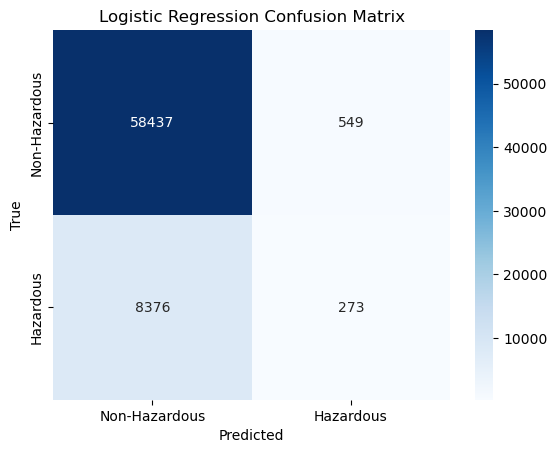

In [88]:
conf_matrix_log_reg = confusion_matrix(y_test, y_pred_log_reg)
sns.heatmap(conf_matrix_log_reg, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Hazardous', 'Hazardous'], yticklabels=['Non-Hazardous', 'Hazardous'])
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Random Forest Model

In [57]:
# Training the Random Forest model
random_forest = RandomForestClassifier(n_estimators=50, class_weight='balanced', max_depth=25, random_state=42)
random_forest.fit(X_train, y_train)

# Predicting and evaluating Random Forest
y_pred_rf = random_forest.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, random_forest.predict_proba(X_test)[:, 1])

print(f"Random Forest Accuracy: {accuracy_rf:.2f}")
print(f"Random Forest ROC-AUC: {roc_auc_rf:.2f}")

# Detailed classification report for Random Forest
report_rf = classification_report(y_test, y_pred_rf, target_names=['Non-Hazardous', 'Hazardous'])
print("Random Forest Classification Report:\n", report_rf)


Random Forest Accuracy: 0.96
Random Forest ROC-AUC: 0.99
Random Forest Classification Report:
                precision    recall  f1-score   support

Non-Hazardous       0.98      0.97      0.98     58986
    Hazardous       0.81      0.89      0.85      8649

     accuracy                           0.96     67635
    macro avg       0.90      0.93      0.91     67635
 weighted avg       0.96      0.96      0.96     67635



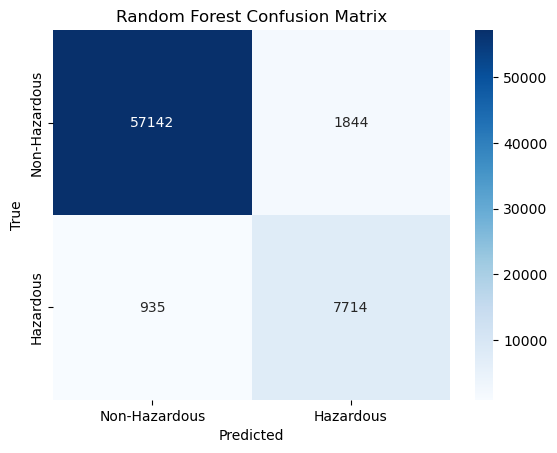

In [86]:
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Hazardous', 'Hazardous'], yticklabels=['Non-Hazardous', 'Hazardous'])
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### ROC Curve Comparison 

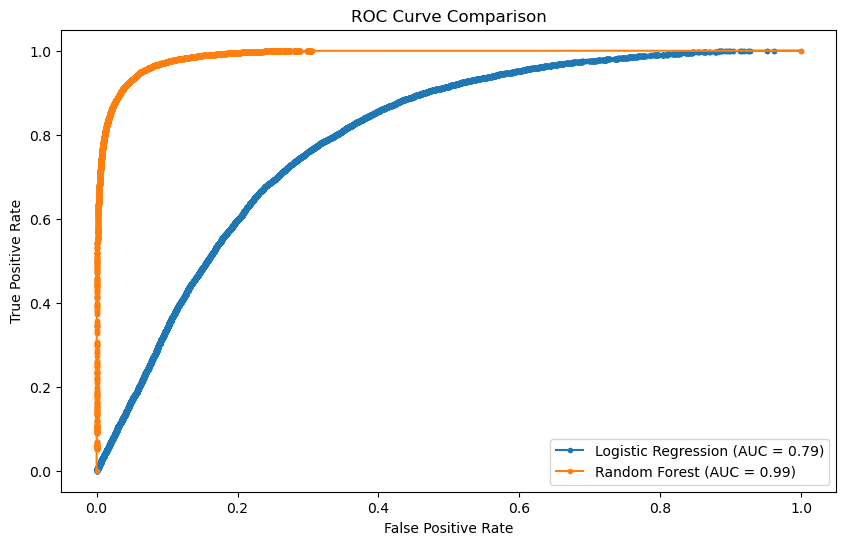

In [65]:
# ROC Curve for both models
fpr_log_reg, tpr_log_reg, _ = roc_curve(y_test, log_reg.predict_proba(X_test)[:, 1])
fpr_rf, tpr_rf, _ = roc_curve(y_test, random_forest.predict_proba(X_test)[:, 1])

plt.figure(figsize=(10, 6))
plt.plot(fpr_log_reg, tpr_log_reg, marker='.', label='Logistic Regression (AUC = {:.2f})'.format(roc_auc_log_reg))
plt.plot(fpr_rf, tpr_rf, marker='.', label='Random Forest (AUC = {:.2f})'.format(roc_auc_rf))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()


## Conclusion

### Model Performance Summary

- **Logistic Regression**:
  - Accuracy: `0.87`
  - ROC-AUC: `0.79`
  - Strengths: Simplicity, interpretability
  - Weaknesses: May underperform on complex patterns in the data

- **Random Forest**:
  - Accuracy: `0.96`
  - ROC-AUC: `0.99`
  - Strengths: Handles complex patterns well, robust to overfitting
  - Weaknesses: More computationally expensive, harder to interpret

### Final Decision

Based on the results, **Random Forest** outperforms Logistic Regression in terms of both accuracy and ROC-AUC, making it the better model for predicting whether a near-earth object is hazardous. The confusion matrix shows that Random Forest also has better class prediction performance
